## Problem Statement

**Curve fitting** is a type of optimization problem that involves finding a curve that best fits a set of data points. The **polynomial curve fitting** problem specifically seeks a polynomial function that closely approximates the underlying relationship between the independent variable (or variables) and the dependent variable in a dataset.

The problem becomes challenging for several reasons:

1. ***Complexity of Data:*** Data can be highly variable, noisy, and may contain outliers. Real-world data is not always clean or follows a simple trend, making the fitting process more complex.

2. ***Overfitting vs. Underfitting:*** A significant challenge is to find the right balance between simplicity and complexity of the model. A polynomial that is too simple may not capture the essential trends (underfitting), while one that is too complex may capture noise rather than the underlying relationship (overfitting).

3. ***Degree of the Polynomial:*** Determining the order of the polynomial that provides the best fit can be difficult. A higher-degree polynomial may better fit the data points but could lead to a lack of generalizability.

4. ***Computational Intensity:*** As the degree of the polynomial increases, the number of coefficients to be determined also increases, which can make the computation more intensive and the problem harder to solve.

A genetic algorithm (GA) is an evolutionary-based optimization technique that can be used to address these challenges in polynomial curve fitting. It works by simulating the process of natural selection where the fittest individuals are selected to produce offspring of the next generation. In the context of polynomial curve fitting, individuals in the population (chromosomes) can represent different coefficients of the polynomial equation.

Genetic algorithms are particularly suitable for this problem due to their ability to search through large and complex spaces, their flexibility, and tolerance for noisy data. A GA can efficiently maneuver through the search space to find a polynomial that provides a good fit to the data while avoiding overfitting.

When using GAs for curve fitting, we must define:

- A **fitness function** to evaluate how well a polynomial fits the data.
- A **selection mechanism** to choose which individuals to mate.
- **Crossover and mutation operators** to generate new offspring.
- A **population size** and a set of potential solution candidates.

The choice of these parameters can significantly affect the performance of the GA in finding an optimal or near-optimal solution for the polynomial curve fitting problem.

In [16]:
#Importing necassary libraries
import numpy as np
import math
import random
import matplotlib.pyplot as plt

## Data Visualization

The next part requires a certain format for the test data. Our data is stored in the CurveFitting-Tests directory, with files named from CurveFitting_test1 to CurveFitting_test4. The first line of each test file tells us the degree of the polynomial equation. The second line shows the range of the coefficients, which is useful for the first step: making an initial population of random chromosomes. The third line lists the number of data points in the file, and the rest of the file contains the x and y coordinates of these points.

In [41]:
pop_size = 200
x = []
y = []

instuc = []
with open('./CurveFitting-Tests/CurveFitting_test4.txt', 'r') as file:
    # Iterate through each line in the file
    for line in file:
        # Split the line into a list of numbers (as strings)
        parts = line.split()

        if len(parts) == 2:
            x.append(float(parts[0]))
            y.append(float(parts[1]))
        else:
            instuc.append(int(parts[0]))

n = instuc[0] + 1
coef_min = x[0]
coef_max = y[0]
x = x[1:]
y = y[1:]

wide_range_y = False
if max(y) > 1e20 or min(y) < -1e20:
    wide_range_y = True

The figures and outputs presented below indicate that ***TestCase3*** has a minimum value on the order of $1e33$. This extremely large number poses a risk of causing computation overflow if not managed appropriately. The potential for error is heightened as the employed cost function involves squaring, which can lead to inaccuracies in the predicted vs. actual y-values due to the power function. To mitigate such risks, the `wide_range_y` variable is used to identify instances of large ranges. Furthermore, the cost function has been adapted to use the absolute value of the error instead of the square to avoid overflow issues.

Polynomial Order: 11 | Minimum Coefficient: -1.0 | Maximum Coefficient: 1.0
Number of Points: 50
Min y value: -379949829948.33 | Max y value:  381827746452.189


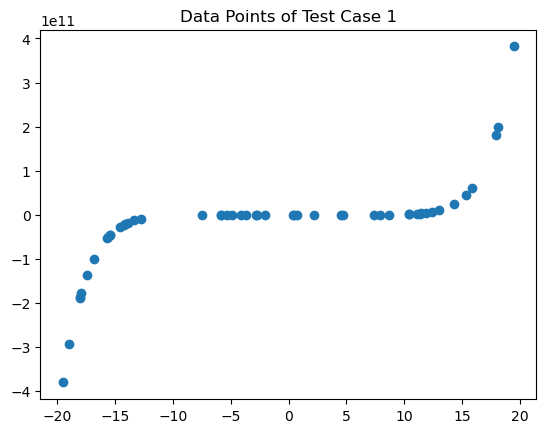

In [18]:
print(f'Polynomial Order: {n} | Minimum Coefficient: {coef_min} | Maximum Coefficient: {coef_max}')
print(f'Number of Points: {len(x)}')
print('Min y value:', min(y), '| Max y value: ', max(y))
plt.scatter(x, y)
plt.title('Data Points of Test Case 1')
plt.show()

Polynomial Order: 11 | Minimum Coefficient: -1.0 | Maximum Coefficient: 1.0
Number of Points: 50
Min y value: -379949829948.33 | Max y value:  381827746452.189


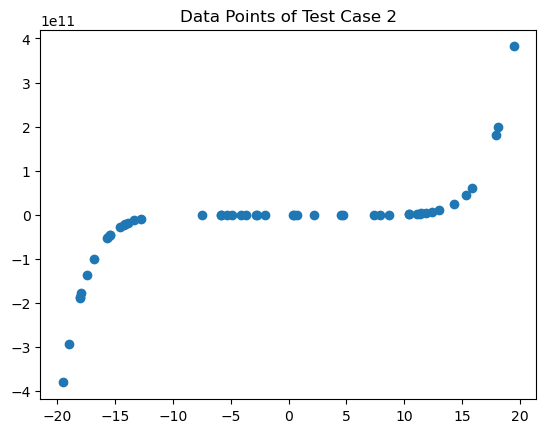

In [19]:
print(f'Polynomial Order: {n} | Minimum Coefficient: {coef_min} | Maximum Coefficient: {coef_max}')
print(f'Number of Points: {len(x)}')
print('Min y value:', min(y), '| Max y value: ', max(y))
plt.scatter(x, y)
plt.title('Data Points of Test Case 2')
plt.show()

Polynomial Order: 11 | Minimum Coefficient: -1.0 | Maximum Coefficient: 1.0
Number of Points: 50
Min y value: -379949829948.33 | Max y value:  381827746452.189


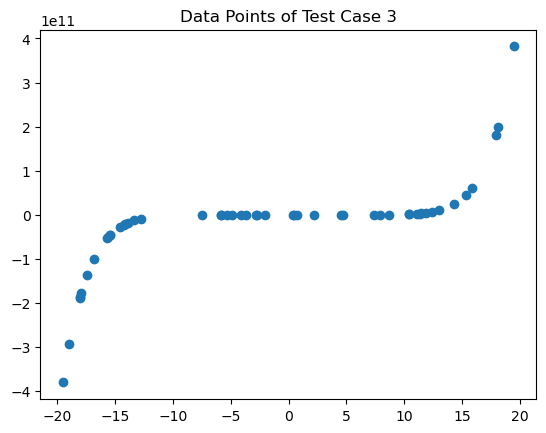

In [20]:
print(f'Polynomial Order: {n} | Minimum Coefficient: {coef_min} | Maximum Coefficient: {coef_max}')
print(f'Number of Points: {len(x)}')
print('Min y value:', min(y), '| Max y value: ', max(y))
plt.scatter(x, y)
plt.title('Data Points of Test Case 3')
plt.show()

Polynomial Order: 11 | Minimum Coefficient: -1.0 | Maximum Coefficient: 1.0
Number of Points: 50
Min y value: -379949829948.33 | Max y value:  381827746452.189


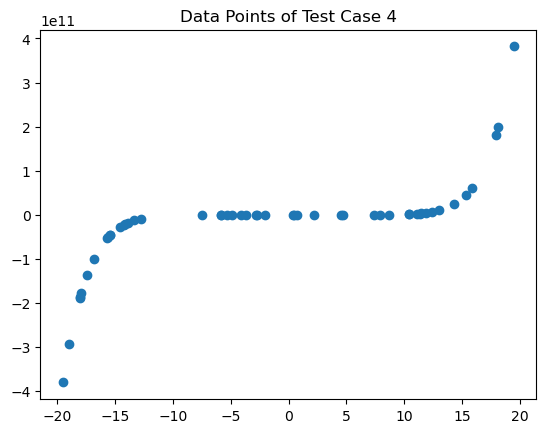

In [21]:
print(f'Polynomial Order: {n} | Minimum Coefficient: {coef_min} | Maximum Coefficient: {coef_max}')
print(f'Number of Points: {len(x)}')
print('Min y value:', min(y), '| Max y value: ', max(y))
plt.scatter(x, y)
plt.title('Data Points of Test Case 4')
plt.show()

## Genetic Algorithm Operators

### Chromosome

Population’s chromosomes are represented by class `Chromosome`, managing various individual modifications. A chromosome represents a unique solution to the main problem, defined as a list of coefficients, with the $i^{th}$ element corresponding to the coefficient of $x^{n-i}$ in the equation. This class leverages global variables x (the x-coordinates of data points), y (the y-coordinates of data points), and n (the order of the polynomial) and it includes the following methods:

- `__init__()`: This method is called when a new class instance is created. It stores the input list in the `self.chr` attribute and calculates the list's fitness level using the `fitFunc()` method.

- `fitFunc()`: This is a fitness function, also commonly known as a cost or loss function, which evaluates the suitability or "fitness" of a proposed solution within a population, aiding in the search for optimal solutions. 
    
    I initially chose the Root Mean Square Error (RMSE) as my fitness function. RMSE quantifies the average magnitude of the error between the values predicted by a model and the actual observed values, as defined by the formula: 
    $$\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$ 
    However, I encountered issues with RMSE when dealing with the extremely large y-values present in **TestCase3**. These large values resulted in high error magnitudes which, when squared, could lead to overflow errors and inaccurate calculations. To address this issue , I modified the cost function to calculate absolute error instead of squared error. This change led me to adopt the Mean Absolute Error (MAE) as it prevents overflow issues, allows for a consistent loss function across all test cases, and serves effectively as the loss function for the local search component within the memetic algorithm (more details on MA in [CF_MA.ipynb](./CF_MA.ipynb)):
    
    $$\mathrm{MAE} = {\frac{1}{n} \sum_{i=1}^{n} |(y_i - \hat{y}_i)|}$$

    MAE is less sensitive to outliers than Mean Squared Error (MSE) because it does not square the errors. In cases where the data may have noise or outliers, the MAE provides a measure of fitness that does not disproportionately penalize these instances, leading to more generalized solutions. Also, since MAE is the average of the absolute differences, it has a direct interpretation as the “average estimation error” in the same units as the output variable. This makes it easier to set acceptable thresholds or goals within the context of the problem at hand. Additionally, MAE treats all errors with the same weighting, regardless of their scale. This characteristic means the fitness would be consistent across different ranges of data.
    
    MAE is relatively straightforward and quick to compute, which is advantageous in GAs and MAs that often perform a multitude of fitness evaluations. Opting for MAE is also strategic as we plan to enhance our genetic algorithm into a memetic algorithm (MA), and MAE serves a dual function, accommodating both contexts by integrating well as a cost function in the MA's local search process.

    

- `mutateSwap()`: During mutation process by `mutatationSwap()`, this function is involved in altering the genetic structure by switching the values of two randomly selected points on the chromosome. (More details about `mutatationSwap()` is discussed further in the code.)

- `mutateComp()`**: Another mutation function, where a single point is randomly chosen and its value is complemented based on a predefined minimum and maximum coefficient interval. The `mutateComp()` function is designed to perform this task. However, this function is not used throughout the algorithm since `mutateSwap()` has been shown to yield superior results. (Further information on `mutateComp()` is provided in the accompanying code documentation.)

About `np.polyval(p,1)`:
It is a function from the NumPy library in Python, used for evaluating the value of a polynomial at specific points. The function takes two main arguments:

1. `p`: An array of coefficients that define the polynomial. The coefficients are ordered from the highest degree to the zeroth degree.

2. `x`: A number, or an array of numbers, at which to evaluate the polynomial. These are the x-values for which you want to calculate the corresponding y-values.

The function computes the polynomial value by substituting the value(s) of x into the polynomial defined by the coefficients p.

In [22]:
class Chromosome:
    global x, y, n
    def __init__(self, chr):
        self.chr = chr
        self.fitness, self.chr_y = self.fitFunc(self.chr)

    #RMSE
    def fitFunc(self, chr):
        self.chr_y = np.polyval(chr, x)
        self.fitness = np.sum([abs(y1 - y2) for (y1, y2) in zip(self.chr_y, y)]) * (1/len(x))
        return self.fitness, self.chr_y
    
    def mutateComp(self, m1):
        self.chr[m1] = coef_max + coef_min - self.chr[m1]
        self.fitness, self.chr_y = self.fitFunc(self.chr)
        return
    
    def mutateSwap(self, m1, m2):
        tmp = self.chr[m1]
        self.chr[m1] = self.chr[m2]
        self.chr[m2] = tmp
        self.fitness, self.chr_y = self.fitFunc(self.chr)
        return

### Initialization (Population Generation)

When initiating a genetic algorithm, the first step is to create a pool of potential solutions, known as individuals, but its size is a crucial setting that influences how effectively the algorithm can explore possible solutions and converge to an optimal or near-optimal solution. When determining the population size, several key factors should be considered:

1. **Diversity**: A larger population size provides a greater diversity of solutions, which can help the algorithm to explore a broader search space and avoid premature convergence to local optima.

2. **Convergence Speed**: Conversely, a smaller population might converge faster but risks getting stuck in a local optimum because there aren't enough diverse solutions to move out of that local region.

3. **Computational Resources**: A larger population requires more computational resources in terms of memory and processing power, as more candidate solutions must be evaluated.

4. **Quality of Solutions**: In general, having more candidate solutions can potentially increase the quality of the final solution, as there is a higher chance of having high-fitness individuals that can be combined to create better offspring.

5. **Balance Between Exploration and Exploitation**: Population size affects the balance between exploration (searching new areas of the solution space) and exploitation (refining existing solutions). A larger population is better at exploration, while a smaller population may exploit a narrow region of the search space more intensively.

The `pop_size` variable is chosen based on the performance of multiple runs with different sizes to find a size that offers a good trade-off.

In [23]:
def generatePop():
    pop = []
    for _ in range(pop_size):
        c = [random.uniform(coef_min, coef_max) for _ in range(n)]
        pop.append(Chromosome(c))
    #print(f'Population of size {len(pop)} generated.')
    return pop

### Selection

The selection process is biased toward choosing individuals with higher fitness scores, which leads to a “survival of the fittest” effect. Two selection methods, namely **tournament selection** and **truncation selection** were tested but the first one proved to have a better performance in multiple runs.

- `tournSelect()`: In tournament selection, a set number of individuals (2 in our case) are chosen at random from the population to compete against each other, much like a tournament. The individual with the highest fitness within this subset is selected as a parent. The process is repeated until enough parents are selected to generate the next population which is controlled with `t_round` parameter.

    Tournament selection gives precise control over the selection pressure. By adjusting the tournament size, you can directly influence how strong the selection should be. A larger tournament size increases selection pressure, which is beneficial in scenarios where you want to converge to a good solution quickly, as might be the case with fitting a curve to a set of data points. Also, It preserves diversity better than some other methods. Since the probability of the best individual being selected is not 100%, it allows some less-fit individuals to be included, maintaining genetic diversity, which is important to avoid premature convergence.

- `truncSelect()`: In truncation selection, the individuals in the population are sorted according to their fitness. Only the top portion of the population (in out case `pop_size/2`) is selected to reproduce, while the rest are discarded. It has high selection pressure which can be advantageous when seeking quick convergence. This method also ensures that the best-performing individuals are selected, which can drive rapid improvement in the population's average fitness level.
    Using this method as the selection function lead to rapid convergence and it didn't reach the requiered performance. It seems that by consistently eliminating a portion of the population, it might ignore potentially useful genetic material that could contribute positively in later generations. 
    
Tournament selection generally maintains diversity better than truncation selection because truncation is harsher in removing lower-ranked individuals from the gene pool. The inherent randomness in choosing competitors for tournaments in a GA ensures that even some sub-optimal contenders are given a chance to pass on their genes, which could include beneficial traits that aren't yet evident.

In [24]:
def tournSelect(pop, t_round=int(pop_size/2), elit=int(pop_size/25)):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)

    #elitism
    #parents = pop[:1]
    #random.shuffle(pop)
    #print('parents', len(parents), parents[0].fitness)

    selected = []
    for _ in range(t_round):
        selected = random.sample(pop, 2)
        selected = sorted(selected, key=lambda chr: chr.fitness)
        #print('selected', len(selected), selected[0].fitness, selected[1].fitness)
        parents.append(selected[0])
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

def truncSelect(pop):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)
    parents = pop[:int(pop_size/2)]
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

### Crossover

Crossover combines the genetic information of two parent solutions to generate new offspring. It is analogous to reproduction and biological crossover, reflecting the natural principle that combining material from two parents can produce offspring inheriting features from both. Crossover contributes significantly to the genetic diversity within the population of potential solutions, allowing GAs to explore a broader search space and potentially improving the algorithm's ability to avoid local optima and converge toward the global optimum.

Using point crossovers in polynomial curve fitting is a good idea because they can effectively combine the building blocks of parent solutions to find the best-fitting polynomial. Each chromosome can represent a different coefficient in the polynomial equation, and the crossover point(s) can ensure that groups of coefficients that work well together are likely to be inherited as a block by offspring. Alse, point crossovers strike a balance between exploring new areas of the solution space (exploration) and refining the best solutions found so far (exploitation).

- `crossover1p()`: In 1-point crossover, a single crossover point is randomly chosen within the genetic representations of the parents. All data beyond that point in the array is swapped between the two parent organisms. This type of point crossover resulted in better performance in multiple runs. 

- `crossover2p()`**: 2-point crossover selects two separate points within the genome. The genes between these two points are exchanged between the parent organisms, which can introduce more variance compared to 1-point crossover because the genes from each parent are mixed more thoroughly. However, this method is not utilized in the subsequent GA as the additional variation, in comparison to the 1-point crossover, appears to diminish the overall performance.

Polynomial coefficients have a natural order where each coefficient impacts the curve in a hierarchical manner. By using 1-point crossover, there is a higher chance that successful combinations of coefficients are passed on together to offspring, thus preserving building blocks of good solutions. A 2-point crossover might disrupt beneficial groupings of these genes by introducing changes in multiple sections of the chromosome, which could lead to a less efficient search for the optimal solution in cases where the order and combination of genes represent important phenotypic traits—in this case, the coefficients that best fit the data points in a curve fitting problem.

In [25]:
def crossover2p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(len(p_pool)):
        # choosing 2 random parents from the pool
        p1, p2 = random.sample(p_pool, 2)
        # crossover occurs based on crossover rate
        if random.random() <= cross_rate:
            co1 = random.randint(0, len(p1.chr) - 1)
            co2 = random.randint(0, len(p1.chr) - 1)
            c1 = p1.chr[:co1] + p2.chr[co1:co2] + p1.chr[co2:]
            c2 = p2.chr[:co1] + p1.chr[co1:co2] + p2.chr[co2:]
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offsprint pool size = {len(offspring)}.')
    return offspring

def crossover1p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(len(p_pool)):
        # choosing 2 random parents from the pool
        p1, p2 = random.sample(p_pool, 2)
        # crossover occurs based on crossover rate
        if random.random() <= cross_rate:
            p1, p2 = random.sample(p_pool, 2)
            co1 = random.randint(0, len(p1.chr) - 1)
            c1 = p1.chr[:co1] + p2.chr[co1:]
            c2 = p2.chr[:co1] + p1.chr[co1:]
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offspring pool size = {len(offspring)}.')
    return offspring

### Mutation

Mutation introduces variability into the population, helping to maintain genetic diversity and prevent premature convergence on suboptimal solutions. It can explore new areas of the solution space that might not be reachable through crossover alone.

- `mutationSwap()`: **Swapping Mutation** involves selecting two positions at random within a chromosome and swapping their values. This choice of pair points can happen multiple times which in our case `mut_point` parameter controls it. This type of mutation resulted in better performance in multiple runs. Same as crossover, probably because it can preserve the relative order of coefficients, maintaining beneficial sequences that have been established to fit parts of the data well.

- `mutationComp()`**: **Complement Mutation** changes a selected gene to a different value, potentially any other value within the gene's range. However, this method is not utilized in the subsequent GA as it can make drastic changes to the coefficients, potentially throwing away valuable progress towards the optimal fit. Swapping mutation makes more subtle changes, allowing a more gradual and stable optimization process. 

While complement mutations can be useful in escaping local optima and exploring more of the solution space, their randomness and larger magnitude of change can be less effective in the fine-tuning stage of a polynomial fitting problem. Swapping mutations offer a balance between exploration and exploitation, possibly leading to better performance in this context.

In [26]:
def mutationSwap(offs, mut_point = 3, mut_rate = 0.2):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            for _ in range(mut_point):
                m1 = random.randint(0, len(offs[i].chr) - 1)
                m2 = random.randint(0, len(offs[i].chr) - 1)
                while m1==m2:
                    m2 = random.randint(0, len(offs[i].chr) - 1)
                offs[i].mutateSwap(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

def mutationComp(offs, mut_point = 3, mut_rate = 0.2):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            for _ in range(mut_point):
                m1 = random.randint(0, len(offs[i].chr) - 1)
                offs[i].mutateComp(m1)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

### Replacement

The replacement or population replacement strategy defines how the individuals (solutions) of a population are chosen for survival into the next generation. This process determines the balance between maintaining diversity in the population and converging towards an optimal solution. 

In this replacement strategy, both parents and their generated offspring are first arranged in order of their fitness levels. Then, a predetermined number of the fittest parents (determined by the 'elitism' parameter `elit`), are replaced with the least fit offspring. This ensures that the best genetic material is preserved in the population for the next generation, while still introducing the new genetic variety represented by the remaining offspring.

In [27]:
def replacePop(p, o, elit=2):
    new_gen = []
    p.sort(key=lambda chr: chr.fitness)
    o.sort(key=lambda chr: chr.fitness)
    #elitisim applied
    new_gen = p[:elit] + o[:int(pop_size)-elit]
    random.shuffle(new_gen)
    
    #print(f'New population of size {len(new_gen)} generated')
    return new_gen

## Results

In [28]:
def mainGA(it_no=1000, mr=0.2, cr=0.8):
    iterations_no = it_no
    mut_rate = mr
    cross_rate = cr
    
    fitness_recorder = []
    tm = []
    last_5_fitness = []
    
    it = 0
    pop = generatePop()
    while (it <= iterations_no):
        parents = tournSelect(pop)
        offspring = crossover1p(parents, cross_rate)
        offspring = mutationSwap(offspring, 5, mut_rate)
        new_gen = replacePop(parents, offspring)

        new_gen.sort(key=lambda chr: chr.fitness)

        if it % 50 == 0:
            print(f'Generation: {it}, Best Fitness Value: {new_gen[0].fitness}')
            fitness_recorder.append(new_gen[0].fitness)
            tm.append(it)
            last_5_fitness.append(new_gen[0].fitness)
            
            if len(last_5_fitness) > 5:
                last_5_fitness.pop(0)

            points = list(zip(x, new_gen[0].chr_y))
            points = sorted(points, key=lambda fx: fx[0])
            my_x, my_y = zip(*points)
            plt.plot(my_x, my_y, color='red')
            plt.scatter(x, y)
            plt.show()

        #ending criteria
        if new_gen[0].fitness == 0:
            print("SUCCESS")
            break
        if len(last_5_fitness) == 5 and (max(last_5_fitness) - min(last_5_fitness)) < 4e-6*n:
            print("Stopping Criterion Met.")
            break

        pop = new_gen
        it += 1 
    return new_gen[0].chr, fitness_recorder, tm

### Test Case 1

- The following observations were seen before parameter fine-tuning which resulted in an increase in mutation rate:
    - The algorithm consistently converges to the same or similar solutions, indicating a possibility of being trapped in a local optimum.
    - The rate of improvement in fitness values slows down or plateaus over successive generations, suggesting that the search might be stuck in a limited area of the solution space.


- After optimizing the mutation and crossover rates over many trials, a fitness value plateau was reached at 2206567919.82 after 300 iterations. This value showed minimal improvement from the fitness value of 2206567919.84, which was obtained at the 100th iteration.
- The nearly plateaued trend visible in the fitness plot indicates that running additional iterations would likely not result in significant performance enhancements for the algorithm.

Generation: 0, Best Fitness Value: 10691327454.003819


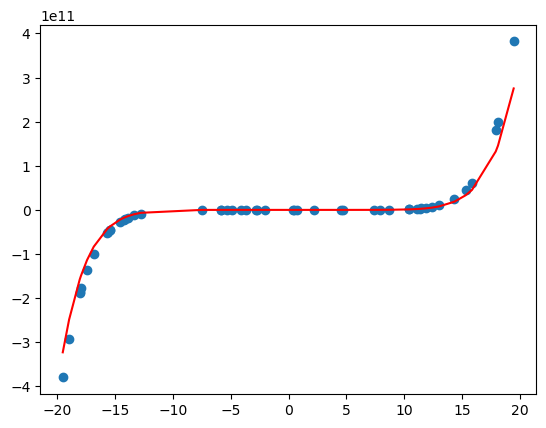

Generation: 50, Best Fitness Value: 2207330307.5595512


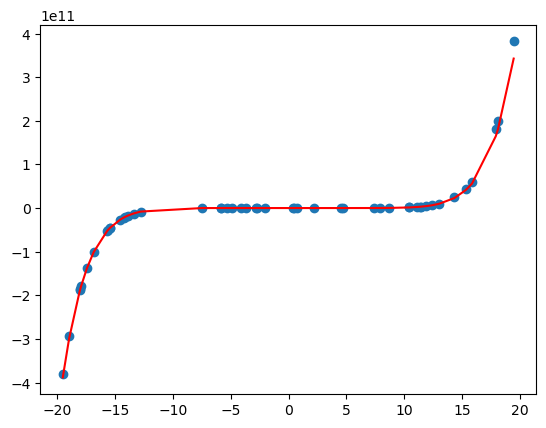

Generation: 100, Best Fitness Value: 2206567919.8440585


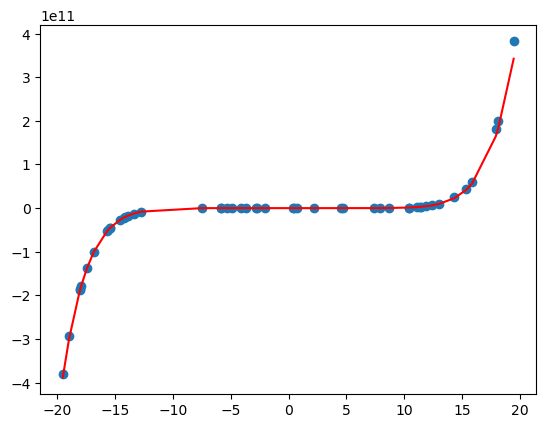

Generation: 150, Best Fitness Value: 2206567919.8188305


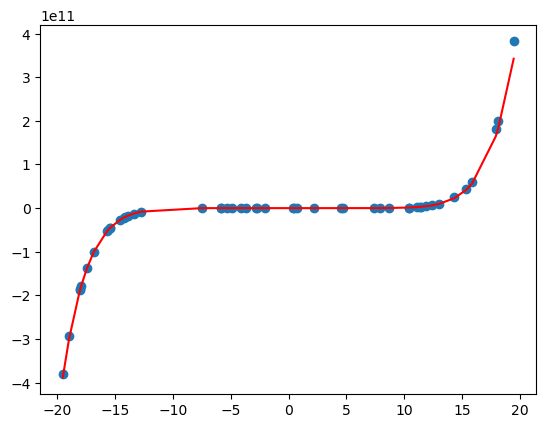

Generation: 200, Best Fitness Value: 2206567919.8188305


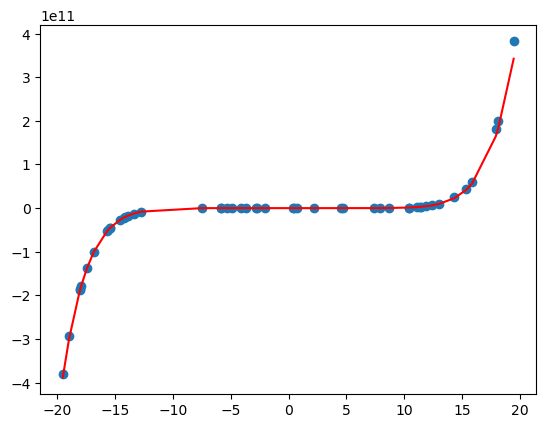

Generation: 250, Best Fitness Value: 2206567919.8188305


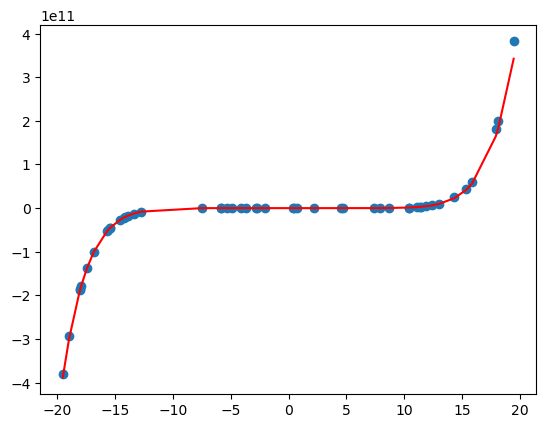

Generation: 300, Best Fitness Value: 2206567919.8188305


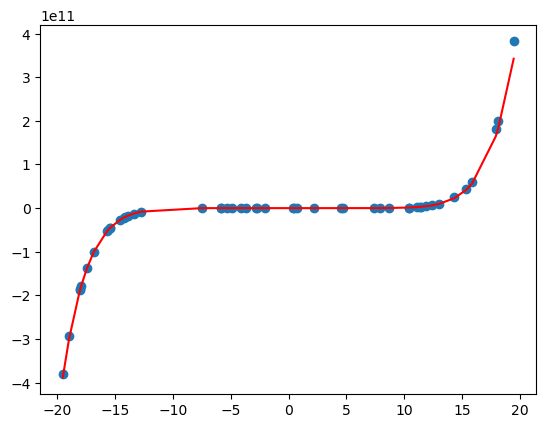

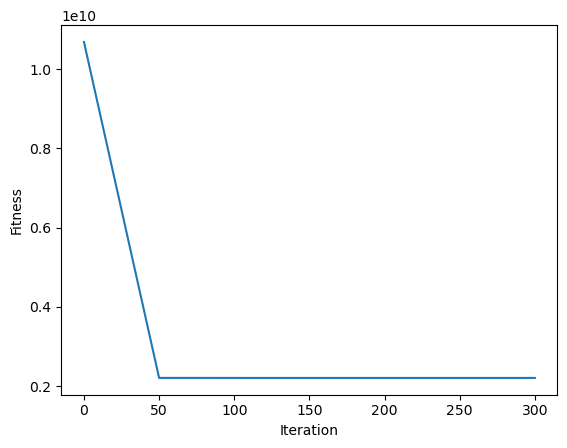

In [36]:
res, recorder, tm = mainGA(300, 0.5, 0.8)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

Generation: 0 | Best Fitness Value: 6158656.5969999945


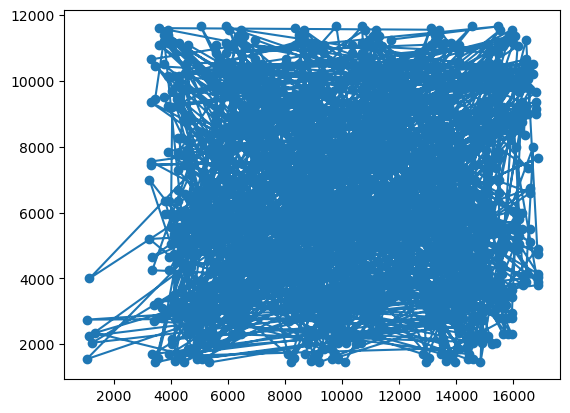

Generation: 1000 | Best Fitness Value: 1746271.9989999987


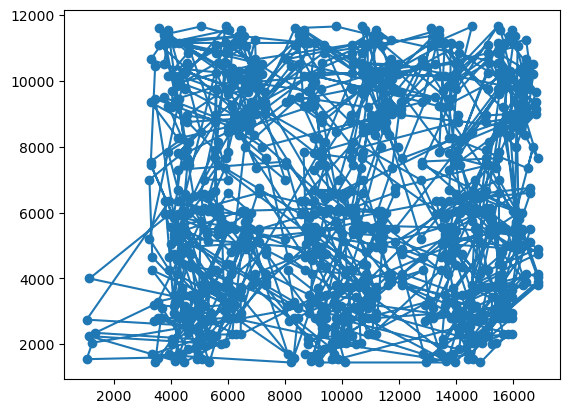

Generation: 2000 | Best Fitness Value: 1267033.1169999978


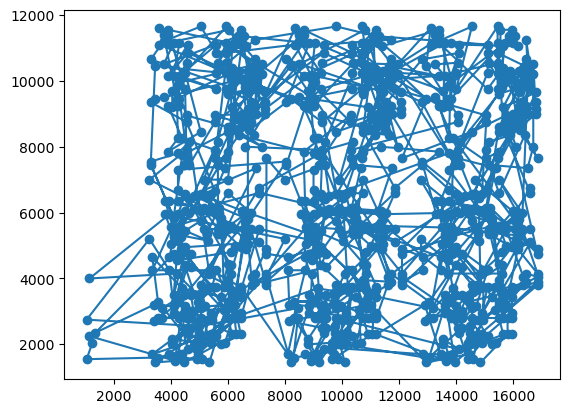

Generation: 3000 | Best Fitness Value: 1046722.0799999989


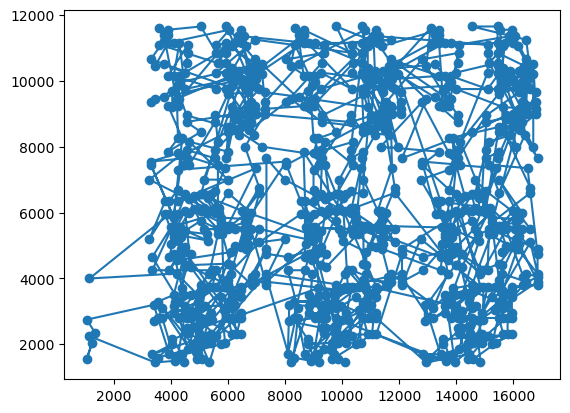

Generation: 4000 | Best Fitness Value: 927767.5880000002


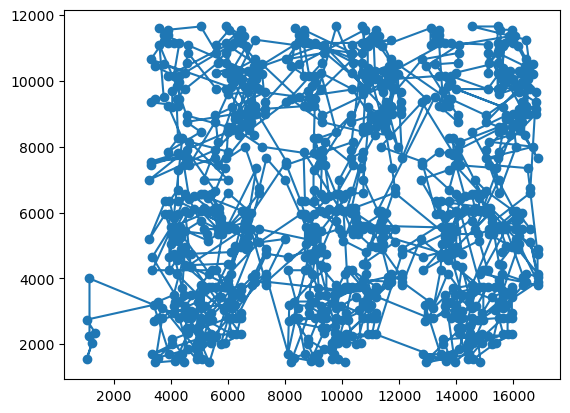

Generation: 5000 | Best Fitness Value: 855497.2679999981


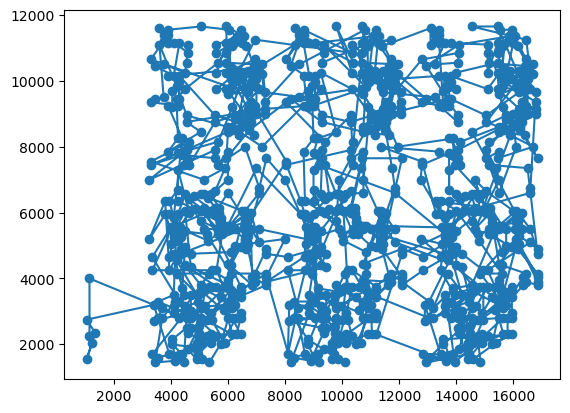

In [ ]:
res_pr, recorder_pr, tm_pr = mainGA(5000, 0.2, 0.9)

### Test Case 2

- The following observations were seen before parameter fine-tuning which resulted in an increase in mutation rate:
    - The algorithm consistently converges to the same or similar solutions, indicating a possibility of being trapped in a local optimum.
    - The rate of improvement in fitness values slows down or plateaus over successive generations, suggesting that the search might be stuck in a limited area of the solution space.
- After optimizing the mutation and crossover rates over many trials, a fitness value plateau was reached at 13495832991.723494 after 300 iterations. 
- The nearly plateaued trend visible in the fitness plot indicates that running additional iterations would likely not result in significant performance enhancements for the algorithm. 
- The observed sudden decline in fitness at iteration 200 suggests that modifying the mutation strategy could yield improvements. Consider either changing the type of mutation function or implementing an adaptive approach where mutation rates are adjusted based on the iteration number. A more dynamic mutation process might help navigate the search space more effectively and potentially lead to better results.

Generation: 0, Best Fitness Value: 624201573845.6564


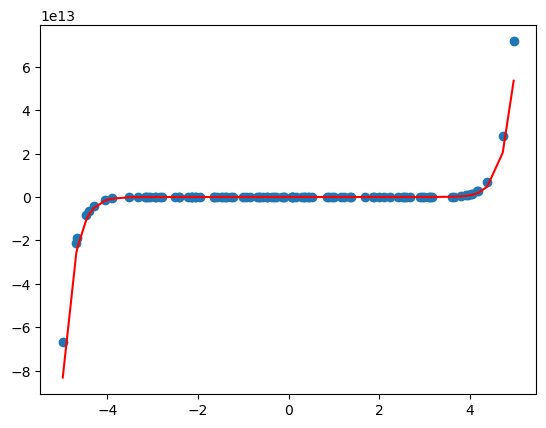

Generation: 50, Best Fitness Value: 31792516309.684563


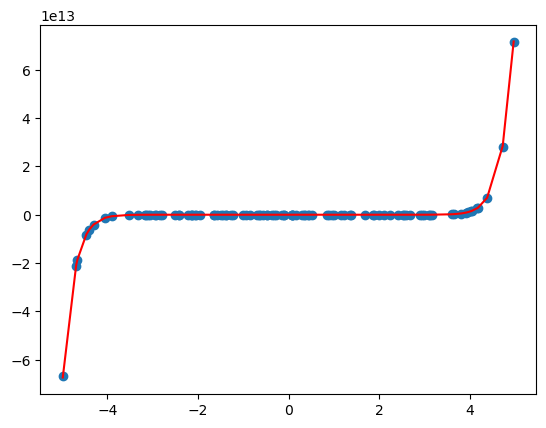

Generation: 100, Best Fitness Value: 31184975329.866867


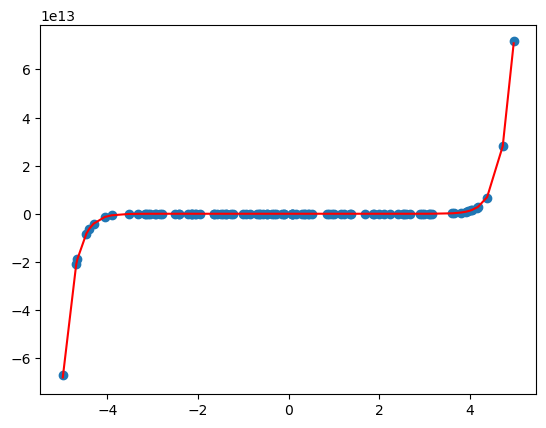

Generation: 150, Best Fitness Value: 30760917236.63524


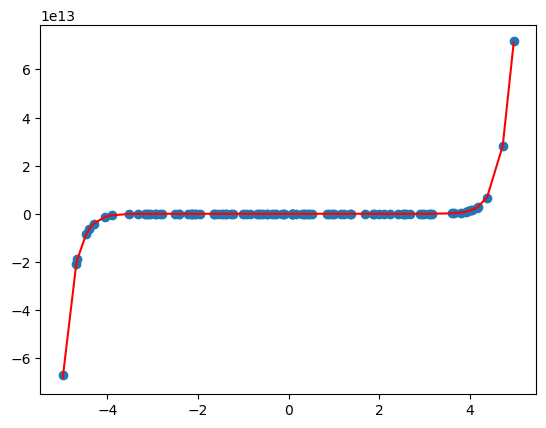

Generation: 200, Best Fitness Value: 13582921783.464624


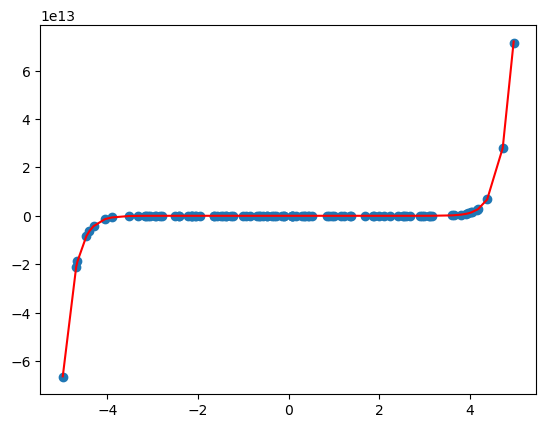

Generation: 250, Best Fitness Value: 13493491191.121796


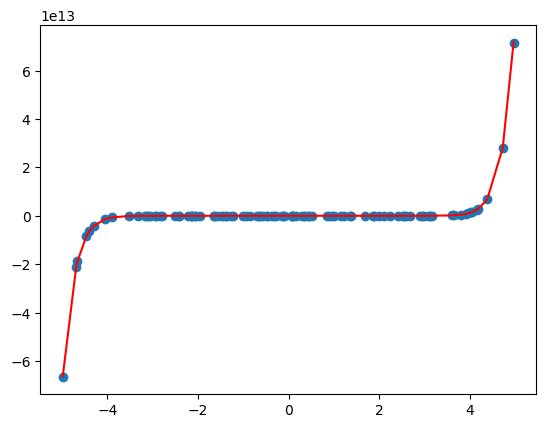

Generation: 300, Best Fitness Value: 13495832991.723494


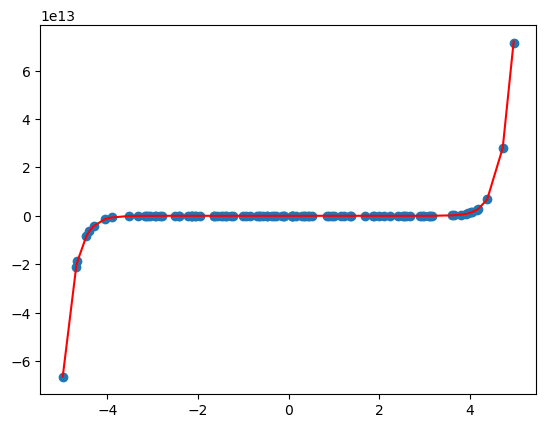

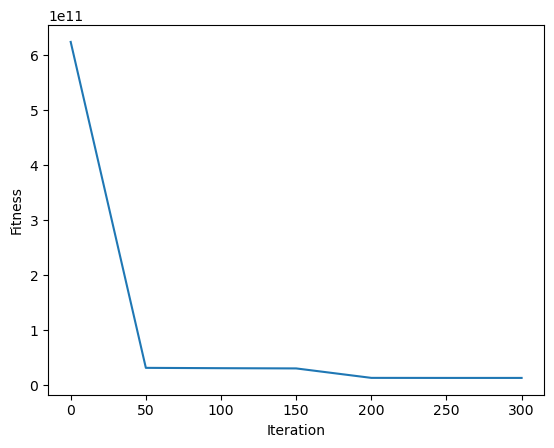

In [38]:
res, recorder, tm = mainGA(300, 0.5, 0.8)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

### Test Case 3

- The following observations were seen before parameter fine-tuning which resulted in an increase in mutation rate:
    - The algorithm consistently converges to the same or similar solutions, indicating a possibility of being trapped in a local optimum.
    - The rate of improvement in fitness values slows down or plateaus over successive generations, suggesting that the search might be stuck in a limited area of the solution space.
- After optimizing the mutation and crossover rates over many trials, a fitness value plateau was reached at 4.1e+29 after 300 iterations. This value showed minimal improvement from the fitness value obtained at the 100th iteration.
- The nearly plateaued trend visible in the fitness plot indicates that running additional iterations would likely not result in significant performance enhancements for the algorithm. 

Generation: 0, Best Fitness Value: 2.100884565758573e+31


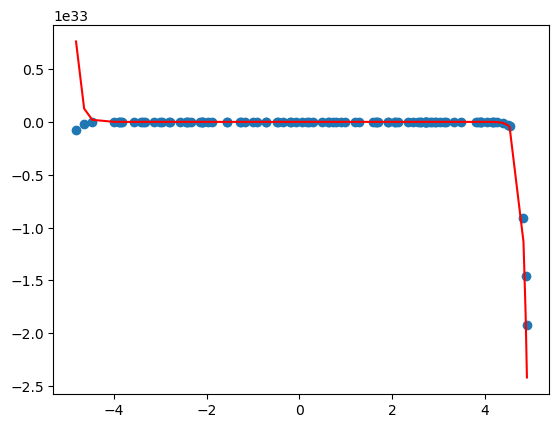

Generation: 50, Best Fitness Value: 1.0967561261782763e+30


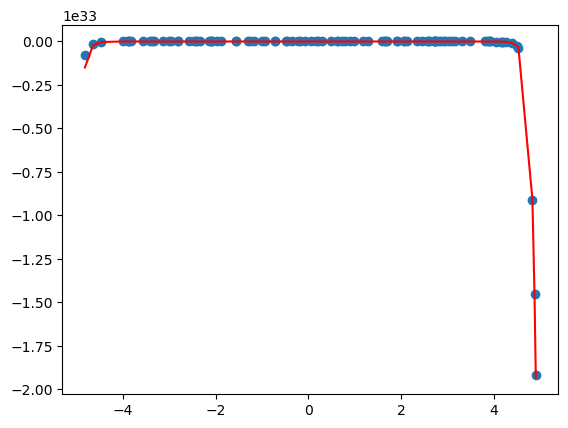

Generation: 100, Best Fitness Value: 4.194054450359144e+29


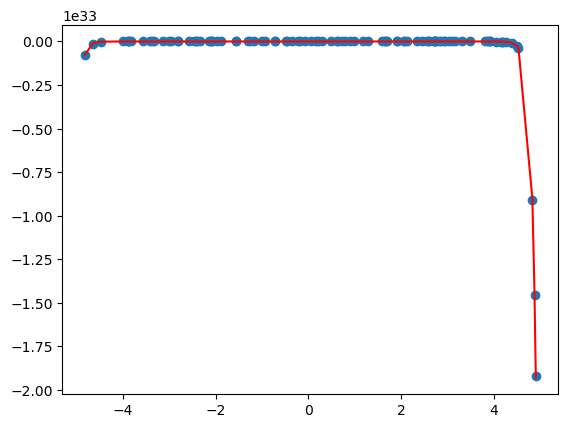

Generation: 150, Best Fitness Value: 4.103018279545425e+29


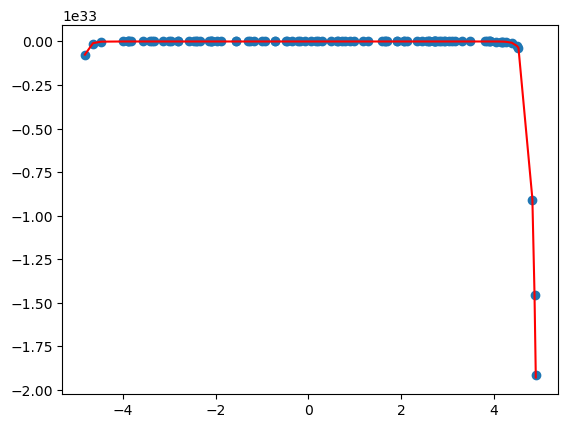

Generation: 200, Best Fitness Value: 4.102488823992598e+29


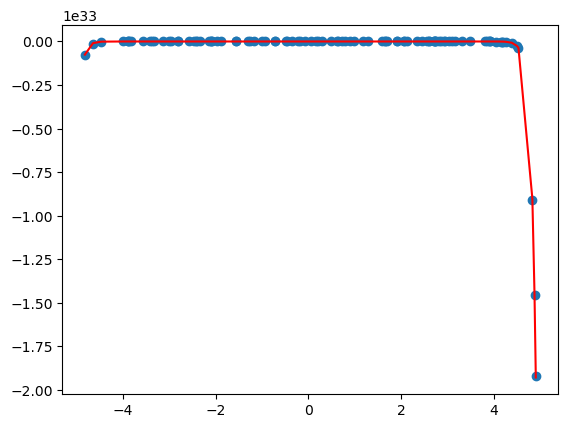

Generation: 250, Best Fitness Value: 4.102488824123211e+29


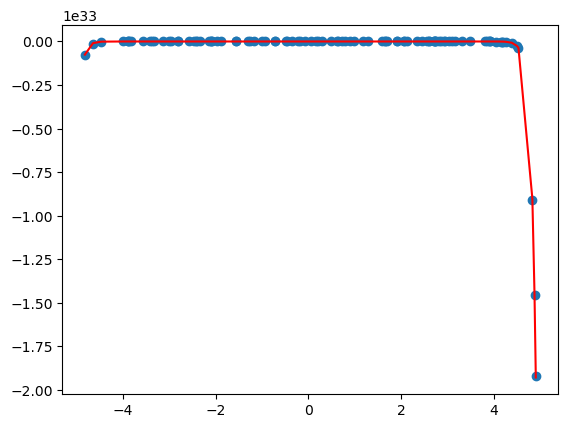

Generation: 300, Best Fitness Value: 4.1024832847333204e+29


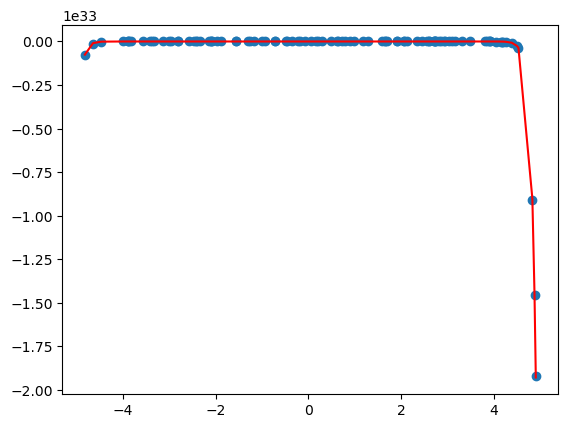

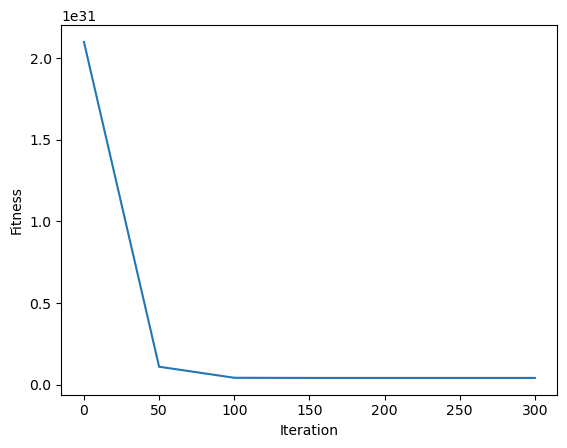

In [40]:
res, recorder, tm = mainGA(300, 0.5, 0.8)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

### Test Case 4

- The following observations were seen before parameter fine-tuning which resulted in an increase in mutation rate:
    - The algorithm consistently converges to the same or similar solutions, indicating a possibility of being trapped in a local optimum.
    - The rate of improvement in fitness values slows down or plateaus over successive generations, suggesting that the search might be stuck in a limited area of the solution space.
- After optimizing the mutation and crossover rates over many trials, a fitness value plateau was reached at 65205191.78 after 300 iterations. This value showed minimal improvement from the fitness value obtained at the 50th iteration.
- The nearly plateaued trend visible in the fitness plot indicates that running additional iterations would likely not result in significant performance enhancements for the algorithm. 

Generation: 0, Best Fitness Value: 368958512.27155155


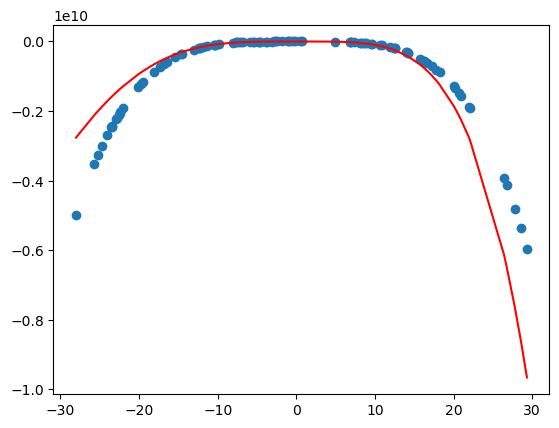

Generation: 50, Best Fitness Value: 64985930.209959306


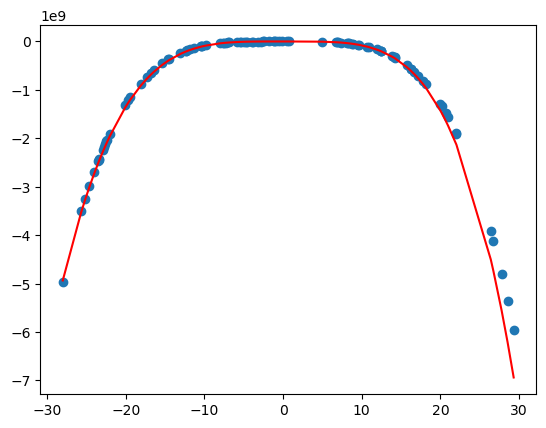

Generation: 100, Best Fitness Value: 65205191.778168686


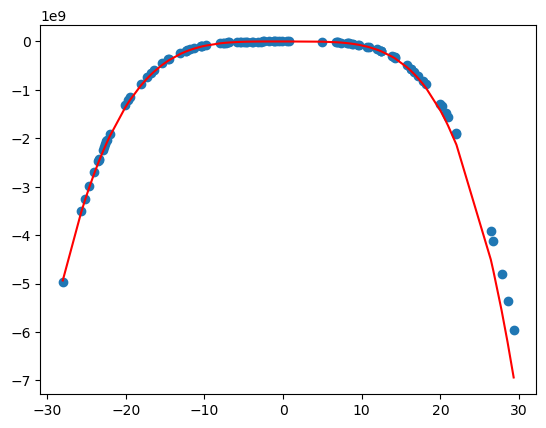

Generation: 150, Best Fitness Value: 65205191.778168686


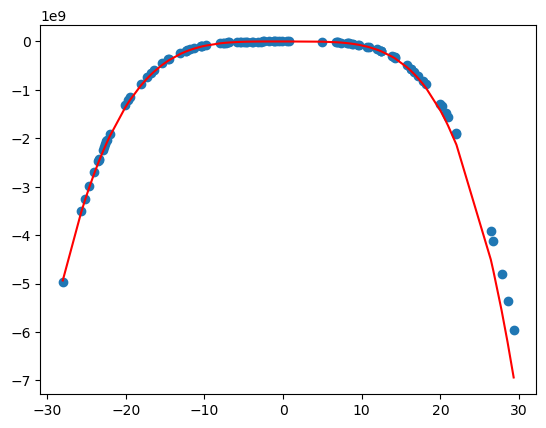

Generation: 200, Best Fitness Value: 65210112.17127728


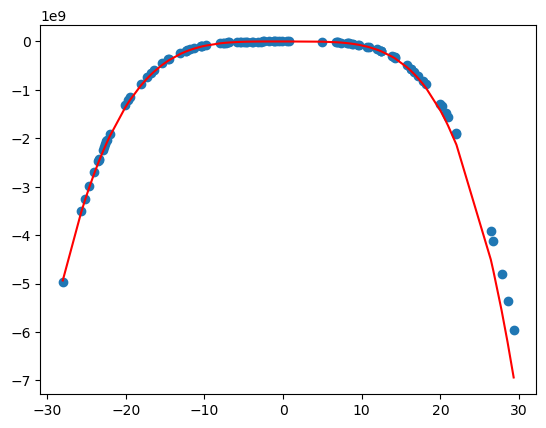

Generation: 250, Best Fitness Value: 65205191.778168686


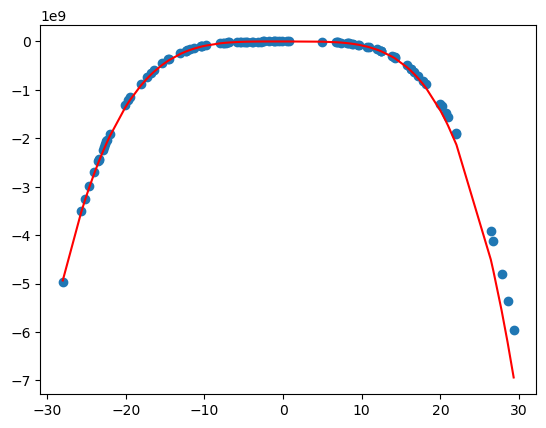

Generation: 300, Best Fitness Value: 65205191.778168686


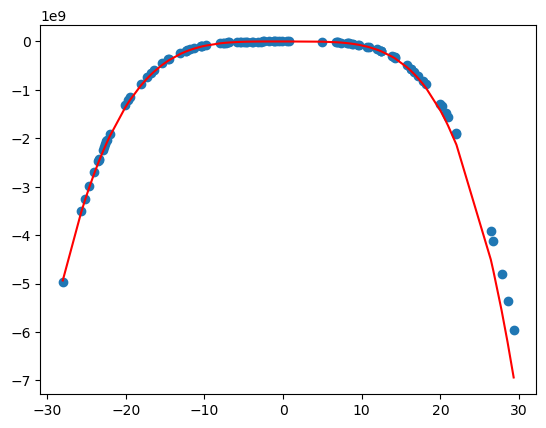

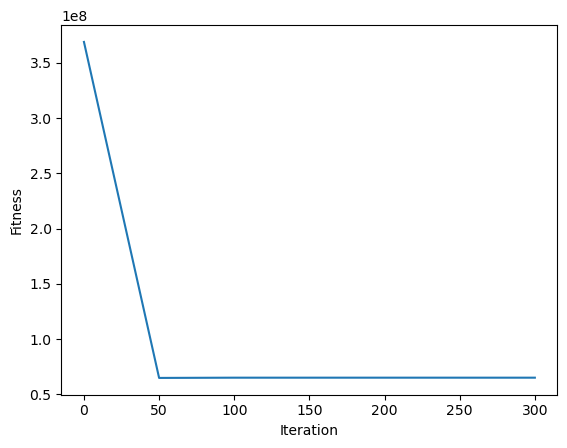

In [48]:
res, recorder, tm = mainGA(300, 0.5, 0.8)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()